## CS439: Final Project
### Detecting Alzheimer's Disease from Handwriting

**Step 1**: Need to load the dataset into our program.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# Load dataset
og_df = pd.read_csv("data.csv")
og_df.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [3]:
#getting shape, datatypes, and information just for reference
og_df.shape

(174, 452)

In [4]:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


In [5]:
og_df.dtypes

ID                  object
air_time1            int64
disp_index1        float64
gmrt_in_air1       float64
gmrt_on_paper1     float64
                    ...   
paper_time25         int64
pressure_mean25    float64
pressure_var25     float64
total_time25         int64
class               object
Length: 452, dtype: object

In [6]:
# Check for any missing values
og_df.isnull().sum()

ID                 0
air_time1          0
disp_index1        0
gmrt_in_air1       0
gmrt_on_paper1     0
                  ..
paper_time25       0
pressure_mean25    0
pressure_var25     0
total_time25       0
class              0
Length: 452, dtype: int64

**Step 2**: Get columns needed for detection models.
For our purposes, we are planning to go with trials 1, 2, and 6 since they are different writing tests (M,G,C) that patients were made to do.
We are also focusing on certain columns of each since we believe these are the most important for the model's predictions:
1. Mean jerk on paper (MJP)
2. Mean jerk in air (MJA)
3. Mean speed on paper (MSP)
4. Mean speed in air (MSA)
5. Total time (TT)
6. Pressure mean (PM)

We will also need the class column to classify each person as either a patient (P) or healthy (H).

In [7]:
og_df['class'] = og_df['class'].map({'P': 0, 'H': 1})

# Keep features ending in trial 1, 2, or 6 
def is_trial_1_2_6(col_name):
    match = re.search(r'(\d+)$', col_name)
    return match and match.group(1) in {'1', '2', '6'}

trial_features = [col for col in og_df.columns if is_trial_1_2_6(col) and col != 'class']

# Prepare data
X = og_df[trial_features].select_dtypes(include=['number']).fillna(0)
y = og_df['class']

# Select top 20 features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top 20 features from trials 1, 2, and 6 ONLY:\n", selected_features)
#air_time, msp, pressure_mean  <- features found useful for 1, 2 and 6
# disp_index, paper_time, total_time <- features found in common for 2, 6

Top 20 features from trials 1, 2, and 6 ONLY:
 Index(['air_time1', 'gmrt_on_paper1', 'mean_speed_on_paper1', 'pressure_mean1',
       'air_time2', 'disp_index2', 'gmrt_in_air2', 'max_x_extension2',
       'mean_jerk_in_air2', 'mean_speed_on_paper2', 'paper_time2',
       'pressure_mean2', 'total_time2', 'air_time6', 'disp_index6',
       'gmrt_on_paper6', 'mean_speed_on_paper6', 'paper_time6',
       'pressure_mean6', 'total_time6'],
      dtype='object')


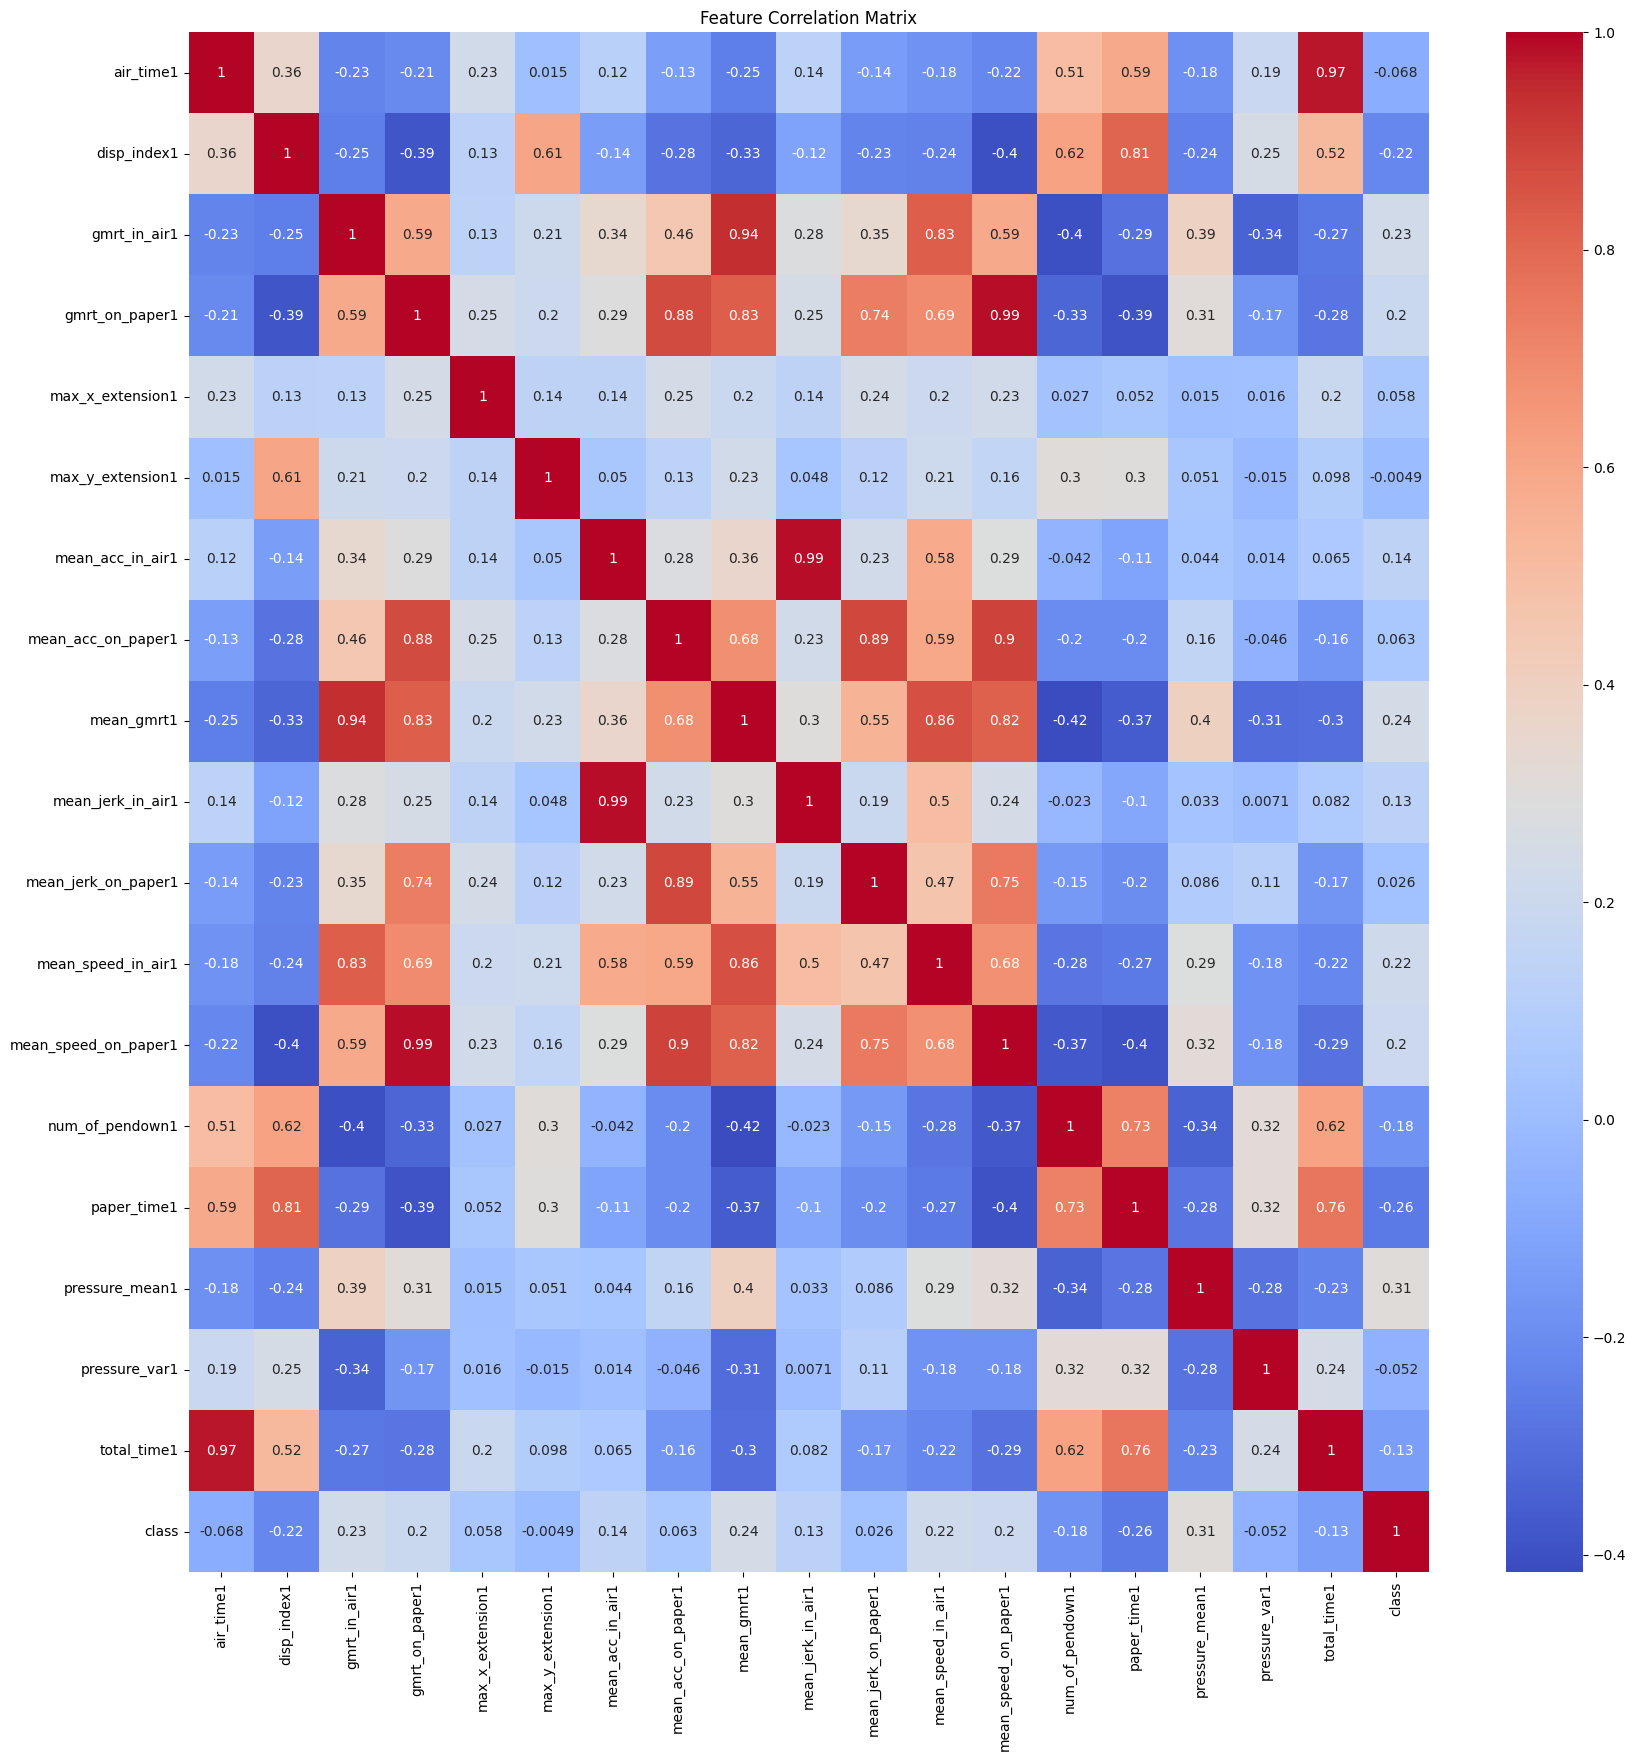

In [8]:
all_features_trial1 = pd.DataFrame(og_df[['air_time1','disp_index1','gmrt_in_air1','gmrt_on_paper1','max_x_extension1','max_y_extension1',                             'mean_acc_in_air1','mean_acc_on_paper1','mean_gmrt1','mean_jerk_in_air1','mean_jerk_on_paper1',
                             'mean_speed_in_air1','mean_speed_on_paper1','num_of_pendown1','paper_time1','pressure_mean1',
                             'pressure_var1','total_time1', 'class']]) 

corr_matrix = all_features_trial1.corr() 
plt.figure(figsize=(20, 20)) 

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Feature Correlation Matrix")

plt.show()

In [9]:
# Select relevant characteristics: MJP, MJA, MSP, MSA, TT, PM, Class(label: patient (0) or healthy (1))
trial1 = pd.DataFrame(og_df[['air_time1','disp_index1','gmrt_in_air1','gmrt_on_paper1','max_x_extension1','max_y_extension1',                             'mean_acc_in_air1','mean_acc_on_paper1','mean_gmrt1','mean_jerk_in_air1','mean_jerk_on_paper1',
                             'mean_speed_in_air1','mean_speed_on_paper1','num_of_pendown1','paper_time1','pressure_mean1',
                             'pressure_var1','total_time1', 'class']])

trial2 = pd.DataFrame(og_df[['air_time2','disp_index2','gmrt_in_air2','gmrt_on_paper2','max_x_extension2','max_y_extension2',                             'mean_acc_in_air1','mean_acc_on_paper1','mean_gmrt1','mean_jerk_in_air1','mean_jerk_on_paper1',
                             'mean_speed_in_air2','mean_speed_on_paper2','num_of_pendown2','paper_time2','pressure_mean2',
                             'pressure_var2','total_time2', 'class']])


trial6 = pd.DataFrame(og_df[['air_time6','disp_index6','gmrt_in_air6','gmrt_on_paper6','max_x_extension6','max_y_extension6',                             'mean_acc_in_air1','mean_acc_on_paper1','mean_gmrt1','mean_jerk_in_air1','mean_jerk_on_paper1',
                             'mean_speed_in_air6','mean_speed_on_paper6','num_of_pendown6','paper_time6','pressure_mean6',
                             'pressure_var6','total_time6', 'class']])

#rename all column headers
#trial1.columns = trial2.columns = trial6.columns = ['AT', 'MSP', 'PM', 'DI', 'PT', 'TT', 'Class']

**Step 3**: Modeling
We are implementing 2 models:
1. Gaussian Naive Bayes
2. Random forest

#### **GAUSSIAN NAIVE BAYES**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def gaussianNBModel(trial) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & est sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Train a NB Classifier (assuming it follows a normal distribution)
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Make prediction
    y_pred = nb_model.predict(X_test)
    
    # analysis

    # Accuracy
    a = accuracy_score(y_test, y_pred)
    print("Accuracy:", a)

    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Classification Report (precision, recall, f1-score)
    cr = classification_report(y_test, y_pred)
    print("Classification Report:\n", cr)

    return a, cr

    

In [11]:
print("Trial1:") 
GNB_trial1_accuracy, GNB_trial1_CR = gaussianNBModel(trial1)

Trial1:
Accuracy: 0.660377358490566
Confusion Matrix:
 [[13 14]
 [ 4 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.48      0.59        27
           1       0.61      0.85      0.71        26

    accuracy                           0.66        53
   macro avg       0.69      0.66      0.65        53
weighted avg       0.69      0.66      0.65        53



- The model is shown to correctly predict whether a patient is healthy or not approximately 66% of the time. 
- Looking at the confusion matrix, there were 12 TP (true positives - 12 people were healthy and were correctly classified), 15 FN (false negatives - 15 healthy people were predicted as patients), 3 FP (false positives - 3 patients were misclassified as healthy), and 23 TN (true negatives - 23 patients got classified correctly).
- Looking at the classification report:
    - Precision: Of all the times the model made a prediction, 80% of predicted healthy people were actually healthy, 61% of predicted patients were actually patient
    - Recall: Of all the actual H & P examples, the model found 44% of actual healthy people correctly, and 88% of actual patients correctly
    - f1-score: For healthy people (class 0), the f-1 score is 57%, while for patients (class 1), the f-1 score is 72%. Falling between the 0.5 - 0.8 range suggests that the model is adequate in terms of making predictions. This average score means this model may not be the best fit for this scenario.

In [12]:
print("Trial2:")
GNB_trial2_accuracy, GNB_trial2_CR = gaussianNBModel(trial2)

Trial2:
Accuracy: 0.6981132075471698
Confusion Matrix:
 [[12 15]
 [ 1 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.44      0.60        27
           1       0.62      0.96      0.76        26

    accuracy                           0.70        53
   macro avg       0.77      0.70      0.68        53
weighted avg       0.78      0.70      0.68        53



In [13]:
print("Trial6:")
GNB_trial6_accuracy, GNB_trial6_CR = gaussianNBModel(trial6)

Trial6:
Accuracy: 0.7547169811320755
Confusion Matrix:
 [[14 13]
 [ 0 26]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.52      0.68        27
           1       0.67      1.00      0.80        26

    accuracy                           0.75        53
   macro avg       0.83      0.76      0.74        53
weighted avg       0.84      0.75      0.74        53



#### **RANDOM FOREST**

In [14]:
from sklearn.ensemble import RandomForestClassifier
def RandomForestModel(trial) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & test sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Train a RF Classifier
    rf_model = RandomForestClassifier(max_depth=10, n_estimators=300, bootstrap=False, min_samples_split=2, min_samples_leaf=1, class_weight='balanced')
    rf_model.fit(X_train, y_train)

    # Make prediction
    y_pred = rf_model.predict(X_test)

    # Accuracy
    a = accuracy_score(y_test, y_pred)
    print("Accuracy:", a)

    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Classification Report (precision, recall, f1-score)
    cr = classification_report(y_test, y_pred)
    print("Classification Report:\n", cr)

    return a, cr

In [15]:
print("Trial1:")
RF_trial1_accuracy, RF_trial1_CR = RandomForestModel(trial1)

Trial1:
Accuracy: 0.6415094339622641
Confusion Matrix:
 [[19  8]
 [11 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.70      0.67        27
           1       0.65      0.58      0.61        26

    accuracy                           0.64        53
   macro avg       0.64      0.64      0.64        53
weighted avg       0.64      0.64      0.64        53



In [16]:
print("Trial2:")
RF_trial2_accuracy, RF_trial2_CR = RandomForestModel(trial2)

Trial2:
Accuracy: 0.6415094339622641
Confusion Matrix:
 [[17 10]
 [ 9 17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64        27
           1       0.63      0.65      0.64        26

    accuracy                           0.64        53
   macro avg       0.64      0.64      0.64        53
weighted avg       0.64      0.64      0.64        53



In [17]:
print("Trial6:")
RF_trial6_accuracy, RF_trial6_CR = RandomForestModel(trial6)

Trial6:
Accuracy: 0.8113207547169812
Confusion Matrix:
 [[24  3]
 [ 7 19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.86      0.73      0.79        26

    accuracy                           0.81        53
   macro avg       0.82      0.81      0.81        53
weighted avg       0.82      0.81      0.81        53



**Step 4**: Comparing Two Models
Given the results of the two models, we are now going to compare the accuracies and differences between the two. For comparison, we will be using matplotlib and seaborn.

In [18]:
#import for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#### **SUPPORT VECTOR MACHINE**

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

def SupportVectorMachines(trial) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & test sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # scale our data 
    sc = StandardScaler().fit(X_train)
    Xtr, Xte = sc.transform(X_train), sc.transform(X_test)

    # Train a SVM Classifier 
    svm = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
    svm.fit(Xtr, y_train)
    y_pred = svm.predict(X_test)

    # Make prediction
    y_pred = svm.predict(Xte)

    # Analysis
    # Accuracy
    a = accuracy_score(y_test, y_pred)
    print("Accuracy:", a)

    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Classification Report (precision, recall, f1-score)
    cr = classification_report(y_test, y_pred)
    print("Classification Report:\n", cr)

    return a, cr

In [20]:
print("Trial1:")
SVM_trial1_accuracy, SVM_trial1_CR = SupportVectorMachines(trial1)

Trial1:
Accuracy: 0.660377358490566
Confusion Matrix:
 [[17 10]
 [ 8 18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.63      0.65        27
           1       0.64      0.69      0.67        26

    accuracy                           0.66        53
   macro avg       0.66      0.66      0.66        53
weighted avg       0.66      0.66      0.66        53



In [21]:
print("Trial2:")
SVM_trial2_accuracy, SVM_trial2_CR = SupportVectorMachines(trial2)

Trial2:
Accuracy: 0.6226415094339622
Confusion Matrix:
 [[14 13]
 [ 7 19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.52      0.58        27
           1       0.59      0.73      0.66        26

    accuracy                           0.62        53
   macro avg       0.63      0.62      0.62        53
weighted avg       0.63      0.62      0.62        53



In [22]:
print("Trial6:")
SVM_trial6_accuracy, SVM_trial6_CR = SupportVectorMachines(trial6)

Trial6:
Accuracy: 0.7169811320754716
Confusion Matrix:
 [[17 10]
 [ 5 21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.63      0.69        27
           1       0.68      0.81      0.74        26

    accuracy                           0.72        53
   macro avg       0.73      0.72      0.72        53
weighted avg       0.73      0.72      0.71        53



#### **LOGISTIC REGRESSION**

In [23]:
from sklearn.linear_model     import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def logistic_regression(trial) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    # Make training & test sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # scale our data 
    sc = StandardScaler().fit(X_train)
    Xtr, Xte = sc.transform(X_train), sc.transform(X_test)

    # Train a SVM Classifier 
    model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)

    # Make prediction
    y_pred = model.predict(Xte)

    # Analysis
    # Accuracy
    a = accuracy_score(y_test, y_pred)
    print("Accuracy:", a)

    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Classification Report (precision, recall, f1-score)
    cr = classification_report(y_test, y_pred)
    print("Classification Report:\n", cr)

    return a, cr

In [24]:
print("Trial1:")
LR_trial1_accuracy, LR_trial1_CR = logistic_regression(trial1)

Trial1:
Accuracy: 0.7169811320754716
Confusion Matrix:
 [[19  8]
 [ 7 19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.72        27
           1       0.70      0.73      0.72        26

    accuracy                           0.72        53
   macro avg       0.72      0.72      0.72        53
weighted avg       0.72      0.72      0.72        53



In [25]:
print("Trial2:")
LR_trial2_accuracy, LR_trial2_CR = logistic_regression(trial2)

Trial2:
Accuracy: 0.660377358490566
Confusion Matrix:
 [[16 11]
 [ 7 19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.59      0.64        27
           1       0.63      0.73      0.68        26

    accuracy                           0.66        53
   macro avg       0.66      0.66      0.66        53
weighted avg       0.67      0.66      0.66        53



In [26]:
print("Trial6:")
LR_trial6_accuracy, LR_trial6_CR = logistic_regression(trial6)

Trial6:
Accuracy: 0.8113207547169812
Confusion Matrix:
 [[20  7]
 [ 3 23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.74      0.80        27
           1       0.77      0.88      0.82        26

    accuracy                           0.81        53
   macro avg       0.82      0.81      0.81        53
weighted avg       0.82      0.81      0.81        53



#### **CATBOOSTER**

In [27]:
from catboost import CatBoostClassifier

def catbooster(trial) :
    # Split data into features & target
    X = trial.drop('class', axis=1)
    y = trial['class']

    cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']

    # Make training & test sets - 30% of data goes to test set, 70% to training - can change random_state to any # - 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # scale our data 
    sc = StandardScaler().fit(X_train)
    Xtr, Xte = sc.transform(X_train), sc.transform(X_test)

    # Train a SVM Classifier 
    model = CatBoostClassifier(verbose=0, random_state=42)
    model.fit(X_train, y_train, cat_features=cat_features)
    y_pred = model.predict(X_test)

    # Analysis
    # Accuracy
    a = accuracy_score(y_test, y_pred)
    print("Accuracy:", a)

    # Confusion Matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Classification Report (precision, recall, f1-score)
    cr = classification_report(y_test, y_pred)
    print("Classification Report:\n", cr)

    return a, cr

In [28]:
print("Trial1:")
catbooster(trial1)

print("Trial2:")
catbooster(trial2)

print("Trial6:")
catbooster(trial6)

Trial1:
Accuracy: 0.6415094339622641
Confusion Matrix:
 [[19  8]
 [11 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.70      0.67        27
           1       0.65      0.58      0.61        26

    accuracy                           0.64        53
   macro avg       0.64      0.64      0.64        53
weighted avg       0.64      0.64      0.64        53

Trial2:
Accuracy: 0.6981132075471698
Confusion Matrix:
 [[16 11]
 [ 5 21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.59      0.67        27
           1       0.66      0.81      0.72        26

    accuracy                           0.70        53
   macro avg       0.71      0.70      0.70        53
weighted avg       0.71      0.70      0.69        53

Trial6:
Accuracy: 0.7735849056603774
Confusion Matrix:
 [[22  5]
 [ 7 19]]
Classification Report:
               precision    recall  f1-score   sup

(0.7735849056603774,
 '              precision    recall  f1-score   support\n\n           0       0.76      0.81      0.79        27\n           1       0.79      0.73      0.76        26\n\n    accuracy                           0.77        53\n   macro avg       0.78      0.77      0.77        53\nweighted avg       0.77      0.77      0.77        53\n')

In [29]:
# Analyszing all of our models accuracy 

GNB_average = (GNB_trial1_accuracy + GNB_trial2_accuracy + GNB_trial6_accuracy)/3
RF_average = (RF_trial1_accuracy + RF_trial2_accuracy + RF_trial6_accuracy)/3
SVM_average = (SVM_trial1_accuracy + SVM_trial2_accuracy + SVM_trial6_accuracy)/3
LR_average = (LR_trial1_accuracy + LR_trial2_accuracy + LR_trial6_accuracy)/3
print(f'GNB Average: {GNB_average}')
print(f'RF Average: {RF_average}')
print(f'SVM Average: {SVM_average}')
print(f'LR Average: {LR_average}')


GNB Average: 0.7044025157232704
RF Average: 0.6981132075471699
SVM Average: 0.6666666666666666
LR Average: 0.7295597484276729
